# Compressing the System

## Overview

### Questions

* How do I compress the system to a target density? 
* What is a packing fraction?

### Objectives

* Show how to compute the **packing fraction** of a system.
* Explain how how an **Updater** is an **operation** that modifies the system when its **Trigger** returns `True`.
* Demonstrate using the **QuickCompress** updater to achieve a target packing fraction.
* Demonstrate using the **MoveSize** tuner to adjust the trial move size.

## Boilerplate code

In [1]:
import hoomd
import math
import copy

The `render` function in the next cell will render a snapshot using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=430, h=430)

def render(snapshot):
    L = snapshot.configuration.box[0]
    vertices=[(-0.5, 0, 0),
               (0.5, 0, 0),
               (0, -0.5, 0),
               (0, 0.5, 0),
               (0, 0, -0.5),
               (0, 0, 0.5)]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=snapshot.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.02)
    
    scene.lights = [fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
                    fresnel.light.Light(direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3)]
    scene.camera = fresnel.camera.orthographic(position=(0, 0, L+1),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L+1)
    scene.background_color = (1,1,1)
    return tracer.sample(scene, samples=1000)

## Packing fraction

Self-assembly in hard particle systems typically occurs at a **packing fraction** above 0.5.
The **packing fraction** is the ratio of the volume occupied by the particles to the volume of the **periodic box**.

So far, this tutorial as **randomized** a system of *N* octahedra in a box with a very low packing fraction and stored that in `random.gsd`.
Initialize a **Simulation** with this configuration and see what packing fraction it is at:

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)
sim.create_state_from_gsd(filename='random.gsd')

Compute the [volume of the octahedron](https://en.wikipedia.org/wiki/Octahedron):

In [4]:
a = math.sqrt(2)/2
V_particle = 1/3 * math.sqrt(2) * a**3

Compute the **packing fraction**:

In [5]:
initial_packing_fraction = sim.state.N_particles * V_particle / sim.state.box.volume
print(initial_packing_fraction)

0.09126759678492466


As you can see, this **packing fraction** is very low and the box volume needs to be significantly reduced to achieve a **packing fraction** above 0.5.

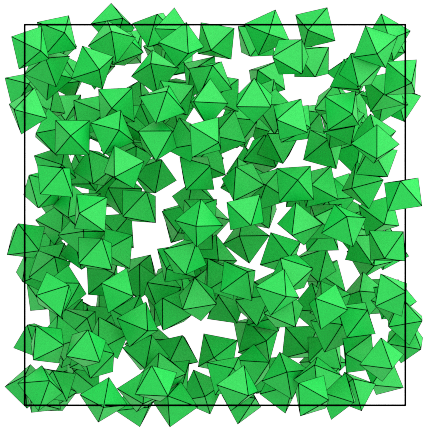

In [6]:
render(sim.state.snapshot)

Use HPMC to move particles into non-overlapping configurations while you compress the system.
Set up the HPMC integrator for the octahedron simulations:

In [7]:
mc = hoomd.hpmc.integrate.ConvexPolyhedron(seed=2)
mc.shape['octahedron'] = dict(vertices=[(-0.5, 0, 0),
                                         (0.5, 0, 0),
                                         (0, -0.5, 0),
                                         (0, 0.5, 0),
                                         (0, 0, -0.5),
                                         (0, 0, 0.5)])
sim.operations.integrator = mc

## The QuickCompress updater

An **Updater** is a type of **operation** in HOOMD-blue that makes changes to the **state**.
To use an **Updater**, first instantiate the object, assign a **Trigger**, and add it to the **Simulation**.
**Simulation** will apply the **Updater** on **time steps** where the **Trigger** returns `True`.
The **Periodic** trigger returns `True` every `period` steps.

**QuickCompress** is an **Updater** that works with HPMC to quickly compress the box to a target volume.
When triggered, **QuickCompress** reduces the box volume by a scale factor, while *allowing slight overlaps between the particles*.
It then waits for the translation and rotation **trial moves** to remove these overlaps before it reduces the volume again.
This process temporarily produces invalid system configurations, but is much quicker than a process that does not allow temporary overlaps.

Compute the final box size with a **packing fraction** above 0.5 and configure a **QuickCompress** to **trigger** every 10 **time steps**.

In [8]:
initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)
final_packing_fraction = 0.58
final_box.volume = sim.state.snapshot.particles.N * V_particle / final_packing_fraction
compress = hoomd.hpmc.update.QuickCompress(trigger=hoomd.trigger.Periodic(10), seed=10, target_box = final_box)

Add the **Updater** to the **Simulation**:

In [9]:
sim.operations.updaters.append(compress)

## The MoveSize tuner

A **Tuner** is another type of **operation**.
**Tuners** make changes to other **operations** to improve performance.
In HPMC, the translation and rotation trial move sizes have a *huge* performance impact.
When the move size is too small it takes many time steps to make appreciable changes to the system.
When the move size is too large very few moves are accepted and it again takes many time steps to make appreciable changes.
The system makes the most progress at moderate move sizes and, in most cases, the optimal **acceptance ratio** is 20%.
The **MoveSize** tuner monitors the **acceptance ratio** and adjusts `d` and `a` to achieve the target.

The optimal move size depends on the density of the system.
**QuickCompress** changes the density rapidly during compression, so use the **MoveSize** tuner to adjust the move sizes regularly:

In [10]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(moves=['a', 'd'],
                                             target=0.2,
                                             trigger=hoomd.trigger.Periodic(10),
                                             max_translation_move=0.2,
                                             max_rotation_move=0.2)
sim.operations.tuners.append(tune)

## Run until complete

When the **QuickCompress** updater achieves the target box size and there are no overlaps between particles, the compression process is **complete**.
The number of time steps needed to achieve this varies based on parameters.
Check the `compress.complete` property regularly and stop running the simulation when the compression completes:

In [11]:
while not compress.complete and sim.timestep < 1e6:
    sim.run(1000)

The `sim.timestep < 1e6` check ensures that this while loop will not waste resources in cases where the compression will never complete.
The loop should complete before that point:

In [12]:
sim.timestep

13000

Check to see if the compression completed successfully:

In [13]:
if not compress.complete:
    raise RuntimeError("Compression failed to complete")

The **MoveSize** tuner should have adjusted the move sizes to relatively small values at the final density:

In [14]:
mc.a['octahedron']

0.04959849083359135

In [15]:
mc.d['octahedron']

0.02769283609586233

Now that the compression is complete, the particles are much closer together and not overlapping, but still arranged randomly.

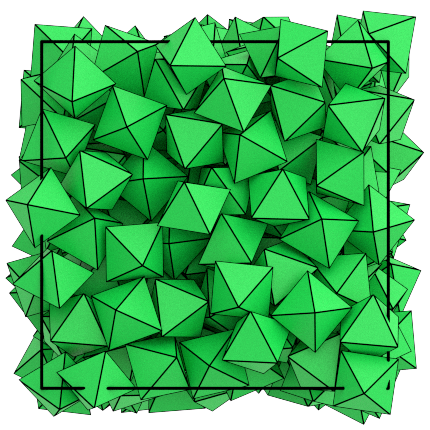

In [16]:
render(sim.state.snapshot)

Save the final configuration to a GSD file for use in the next stage of the simulation:

In [17]:
hoomd.dump.GSD.write(state=sim.state, filename='compressed.gsd')

[Previous section](04-Randomizing-the-System.ipynb). [Next section](06-Equilibrating-the-System.ipynb).